In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-marathi/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-marathi/classification')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,headline,label
0,सचिन तेंडुलकरने बाळासाहेबांच्या आठवणींना दिला ...,state
1,"बहुजन वंचित आघाडीची पहिली यादी जाहीर, प्रकाश आ...",state
2,"गृहमंत्रिपद हे पार्ट टाइम नाही, राजीनामा द्या,...",state
3,पुण्यात आघाडीचा पोपट पुन्हा जिवंत !,state
4,शरद पवार यांनी मिलिंद नार्वेकर यांच्या कानात क...,state


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,headline,label
0,पहाटे 3:30 वाजता बीग बींनी गायल 'हे' रॅप साँग,entertainment
1,राष्ट्रपती आणि पंतप्रधानांनी वाहिली श्रीदेवींन...,entertainment
2,सायरा बानोंना जागेसाठी धमकावणाऱ्या बिल्डराविरो...,entertainment
3,"मुंबईत पहिल्यांदाच पन्नाशी पार, राज्यात सरासरी...",state
4,अण्णांची मनधरणी करण्यासाठी गिरीश महाजन राळेगणस...,state


In [8]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
state 6035
entertainment 2644
sports 994


In [9]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
entertainment 679
state 1512
sports 228


In [10]:
train_df['headline'][0]

'सचिन तेंडुलकरने बाळासाहेबांच्या आठवणींना दिला उजाळा'

In [11]:
train_df.shape, valid_df.shape

((9673, 2), (2419, 2))

In [12]:
train_df[train_df['headline'].isnull()].shape, valid_df[valid_df['headline'].isnull()].shape

((0, 2), (0, 2))

In [13]:
label_cols = list(range(1,train_df.shape[1]))

In [14]:
print(label_cols)

[1]


In [15]:
id_to_col = list(train_df.columns)

In [16]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [17]:
class MarathiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/marathi_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [18]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/marathi_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [19]:
# 30,000 is the vocab size that we chose in sentencepiece
marathi_vocab = Vocab(itos)

In [20]:
tokenizer = Tokenizer(tok_func=MarathiTokenizer, lang='mr')

In [21]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [22]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=marathi_vocab, bs=16)

In [23]:
data_lm.save()

In [24]:
data_lm.show_batch()

idx,text
0,x bo s ▁शरद ▁पवार ▁यांनी ▁मिलिंद ▁नार ्वे कर ▁यांच्या ▁कानात ▁काय ▁सांगितलं ▁असेल ? ▁x x bo s ▁ग्रेट ▁भेट मध्ये ▁अंजली ▁भागवत ▁- ▁भाग ▁3 ▁x x bo s ▁' तारक ▁मेहता . . ' चा ▁कलाकार ▁विशाल ▁ठ क्कर ▁11 ▁दिवस ांपासून ▁बे पत्ता ▁x x bo s ▁' द ंगल ' मुळे ▁ स्मा ॅल ▁स्क्रीन ▁थिएटर ्स ला ▁फायदा ▁x x bo s ▁चाह
1,"▁पंजाब चा ▁दिल्लीवर ▁ दणदणीत ▁विजय ▁x x bo s ▁सलमान सोबत ▁कुठली ▁अभिनेत्री ▁करणार ▁' बी ग ▁बॉस ' चं ▁अँ कर ींग ? ▁x x bo s ▁' नो ▁ हेल्म ेट - नो ▁पेट्रोल ' ला ▁पुणेकर ांचा ▁विरोध , ▁पेट्रोल ▁पंप ▁संघटनेचा ही ▁बंद चा ▁इशारा ▁x x bo s ▁कोलकाता ▁ नाईट ▁रायडर्स कडून ▁राजस्थान ▁रॉयल्स चा ▁6 ▁गडी ▁राखून ▁पराभव ▁x x bo s"
2,"▁' मैदान - ए - जंग ' ▁! ▁x x bo s ▁' महाराष्ट्र ▁रज नी ' ▁चुकीच्या ▁ठिकाणी च ▁! , ▁आग ▁व िझ ली ▁आता ▁राजकारण ▁पेट लं ▁x x bo s ▁ <unk> ▁बाप्पा मोर या रे ▁: ▁अंबा नी ंच्या ▁घरच्या ▁गणपती ला ▁ लोट लं ▁बा ॅल ि वूड ▁x x bo s ▁' आ धार ▁कार्ड ' ची ▁नोंदणी ▁आता ▁गॅस ▁वि तर क"
3,"▁' फ िक्स ' ▁x x bo s ▁ऑपरेशन ▁' नगर ' ▁नंतर ▁हे ▁आहे ▁भाजप चं ▁पुढ चं ▁लक्ष्य ▁x x bo s ▁माझ्या विरोधात ▁कट ात ▁पक्ष ातील ▁विरोधक ▁सहभागी - खड से ▁x x bo s ▁आमदार ▁बच्च ू ▁कडू ▁यांना ▁अचल पूर ▁कोर्ट ाकडून ▁7 ▁महिन्यां ची ▁शिक्षा ▁x x bo s ▁राज्यात ▁डान्स ▁बार ▁पुन्हा ▁सुरू ▁होणार , ▁सुप्री म ▁कोर्ट ाने ▁दिला ▁मोठा ▁निर्णय"
4,"▁सहभाग ामुळे ▁अशी ▁बदल तील ▁समीकरण ं ▁x x bo s <unk> ▁v <unk> id e o ▁: गु हा गर मध्ये ▁समुद्र ातून ▁आलेली ▁महाकाय ▁मग र ▁येत ▁होती ▁वस्ती कडे ▁पण . . . ▁x x bo s ▁आमीर ▁खान ने ▁घेतली ▁अण्णां ची ▁भेट ▁x x bo s ▁राजू ▁शेट्टी ही ▁आता ▁देणार ▁पवार ांना ▁आव्हान , ▁' स ्वा भिमान ी ' चा ▁ठराव ▁मंजूर ▁x"


In [25]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [26]:
# Loading the pretrained language model on kannada wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-marathi/language-model/MarathiDataset/models/fourth_mr_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (9673 items)
x: LMTextList
▁x x bo s ▁सचिन ▁तेंडुलकर ने ▁बाळासाहेब ांच्या ▁आठवणी ंना ▁दिला ▁उ जाळ ा,▁x x bo s ▁बहुजन ▁वंचित ▁आघाडी ची ▁पहिली ▁यादी ▁जाहीर , ▁प्रकाश ▁आंबेडकरांच्या ▁मतदारसंघ ावरुन ▁स स्पे ं न्स ▁कायम,▁x x bo s ▁गृह मंत्रिपद ▁हे ▁पार्ट ▁टाइम ▁नाही , ▁राजीनामा ▁द्या , ▁ तृप्त ी ▁देसाई ंची ▁मुख्यमंत्र्या ंवर ▁टीका,▁x x bo s ▁पुण्यात ▁आघाडी चा ▁पोपट ▁पुन्हा ▁जिवंत ▁!,▁x x bo s ▁शरद ▁पवार ▁यांनी ▁मिलिंद ▁नार ्वे कर ▁यांच्या ▁कानात ▁काय ▁सांगितलं ▁असेल ?
y: LMLabelList
,,,,
Path: /home/gaurav/PycharmProjects/nlp-for-marathi/classification;

Valid: LabelList (2419 items)
x: LMTextList
▁x x bo s ▁पहाटे ▁3 : 30 ▁वाजता ▁बी ग ▁बी ंनी ▁गाय ल ▁' हे ' ▁रॅप ▁स ाँग,▁x x bo s ▁राष्ट्रपती ▁आणि ▁पंतप्रधान ांनी ▁वाहिली ▁श्री देवी ंना ▁श्रद्धांजली,▁x x bo s ▁साय रा ▁बा नो ंना ▁जागे साठी ▁धमकाव णाऱ्या ▁बिल्डर ाविरोधात ▁गुन्हा ▁दाखल,▁x x bo s ▁मुंबईत ▁पहिल्यांदाच ▁पन्ना शी ▁पार , ▁राज्यात ▁सरासरी ▁55 ▁टक्के ▁मतदान,▁x x bo s ▁अण्णां ची ▁मन

In [27]:
# Fine tuning the prtrained LM on current dataset

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


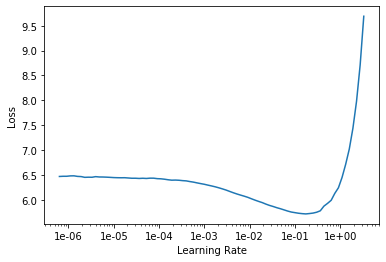

In [29]:
learn.recorder.plot()

In [30]:
learn.freeze()

In [31]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.858786,4.580367,0.347940,00:13


In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.200404,4.366959,0.368086,00:15
1,3.923784,4.179106,0.390316,00:15
2,3.606315,4.116975,0.400389,00:15
3,3.326075,4.124375,0.401900,00:15
4,3.174588,4.142337,0.401900,00:15


In [34]:
learn.predict('सीमा भागातील मराठी',n_words=10)

"सीमा भागातील मराठी ▁पाहिले ▁तर ▁म्हणाले ▁' का न्ह वी ' ▁x x"

In [35]:
learn.save_encoder('fine_tuned_enc')

In [36]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=marathi_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [37]:
data_clas.show_batch()

text,target
"▁x x bo s <unk> ▁l ive ▁cricket <unk> <unk> co re , <unk> ▁v s <unk> ▁2 nd ▁test , ▁4 th ▁ <unk> day - ▁ल ंच नंतर ▁ऑस्ट्रेलिया ला ▁दोन ▁धक्के , ▁शमी ने च ▁घेतल्या ▁दोन्ही ▁विकेट , ▁पेन - ▁फिंच ▁बाद",sports
▁x x bo s <unk> ▁v <unk> id e o ▁: ▁x x re p ▁4 ▁ . ▁आणि ▁हा ▁' ब च्च ू ' ▁पोह ायला ▁लागला ; ▁कासव ावर ही ▁ फिज िओ थेर पी ची ▁जादू,state
"▁x x bo s <unk> der <unk> : ▁प्रो ग्रेस िव ▁सु प्रा न्यू क्ल ियर ▁पाल ्स ी ▁डि स ऑर्डर ▁या ▁आजार ाने ▁घेतले ▁का दर ▁खान चे ▁प्राण , ▁काय ▁आहे ▁हा ▁आजार ?",entertainment
▁x x bo s <unk> ▁i sha a nd a n and w ed d ing ▁: ▁ईश ा ▁- ▁आनंद ▁यांच्या ▁ग्रॅ ंड ▁रि से प ्शन ची ▁खास ▁ब ात . . .,entertainment
"▁x x bo s ▁' ल िव्ह ▁इन ▁रि लेशन ' मध्ये ▁राहणाऱ्या ▁तरुणी ने ▁संपव ले ▁आयुष्य , ▁आत्महत्ये चा <unk> ▁l i v e ▁व्हिडिओ ▁घटना ▁सी सी टी व्ही त ▁कैद",state


In [38]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [39]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [40]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9673 items)
x: TextList
▁x x bo s ▁सचिन ▁तेंडुलकर ने ▁बाळासाहेब ांच्या ▁आठवणी ंना ▁दिला ▁उ जाळ ा,▁x x bo s ▁बहुजन ▁वंचित ▁आघाडी ची ▁पहिली ▁यादी ▁जाहीर , ▁प्रकाश ▁आंबेडकरांच्या ▁मतदारसंघ ावरुन ▁स स्पे ं न्स ▁कायम,▁x x bo s ▁गृह मंत्रिपद ▁हे ▁पार्ट ▁टाइम ▁नाही , ▁राजीनामा ▁द्या , ▁ तृप्त ी ▁देसाई ंची ▁मुख्यमंत्र्या ंवर ▁टीका,▁x x bo s ▁पुण्यात ▁आघाडी चा ▁पोपट ▁पुन्हा ▁जिवंत ▁!,▁x x bo s ▁शरद ▁पवार ▁यांनी ▁मिलिंद ▁नार ्वे कर ▁यांच्या ▁कानात ▁काय ▁सांगितलं ▁असेल ?
y: CategoryList
state,state,state,state,state
Path: /home/gaurav/PycharmProjects/nlp-for-marathi/classification;

Valid: LabelList (2419 items)
x: TextList
▁x x bo s ▁पहाटे ▁3 : 30 ▁वाजता ▁बी ग ▁बी ंनी ▁गाय ल ▁' हे ' ▁रॅप ▁स ाँग,▁x x bo s ▁राष्ट्रपती ▁आणि ▁पंतप्रधान ांनी ▁वाहिली ▁श्री देवी ंना ▁श्रद्धांजली,▁x x bo s ▁साय रा ▁बा नो ंना ▁जागे साठी ▁धमकाव णाऱ्या ▁बिल्डर ाविरोधात ▁गुन्हा ▁दाखल,▁x x bo s ▁मुंबईत ▁पहिल्यांदाच ▁पन्ना शी ▁पार , ▁राज्यात ▁सरासरी ▁55 ▁टक्के ▁मतदान,▁x x 

In [41]:
learn.freeze()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


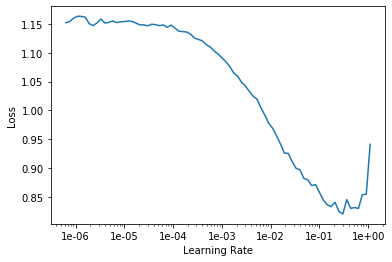

In [43]:
learn.recorder.plot()

In [44]:
learn.loss_func.func

CrossEntropyLoss()

In [45]:
kappa = KappaScore()

In [46]:
learn.metrics = [kappa, accuracy]

In [47]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.392011,0.292001,0.794212,0.895411,00:10


In [48]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.341777,0.235645,0.838608,0.916494,00:11


In [49]:
learn.save('second-full')

In [50]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.217396,0.207422,0.866450,0.930550,00:20
1,0.151769,0.203128,0.875057,0.935511,00:20
2,0.099687,0.207877,0.871078,0.933030,00:21
3,0.048284,0.226651,0.872726,0.933444,00:20
4,0.035421,0.229272,0.872960,0.933444,00:20


Better model found at epoch 0 with accuracy value: 0.9305498003959656.
Better model found at epoch 1 with accuracy value: 0.935510516166687.


In [51]:
learn.predict('धक्कादायक! एक्स्प्रेसमध्ये महिला कोचच्या')

(Category state, tensor(2), tensor([0.0035, 0.0022, 0.9944]))

In [52]:
learn.predict("नरेंद्र मोदी गोव्याला रवाना, पर्रिकर यांच्या पार्थिवाचे अंत्यदर्शन घेणार")

(Category state, tensor(2), tensor([0.0132, 0.0030, 0.9838]))

In [53]:
learn.predict("सलमान आणणार स्वत:चं चॅनेल?")

(Category entertainment, tensor(0), tensor([0.9748, 0.0130, 0.0122]))

In [54]:
learn.predict("धमा’केदार’! टीम इंडियासाठी केली ‘ही’ सर्वोत्तम कामगिरी")

(Category sports, tensor(1), tensor([0.0066, 0.9908, 0.0026]))